<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex07/leonardo_lellis/Aula_7_Exerc%C3%ADcio_Leonardo_de_Lellis_Rossi_RA261900.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Leonardo de Lellis Rossi RA261900"
print(f'Meu nome é {nome}')

Meu nome é Leonardo de Lellis Rossi RA261900


Neptune charts: https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-67

parameters: https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-67/all?path=parameters%2F

In [2]:
debug = False
checkinpoint = True
save_in_drive = True

#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

In [3]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

In [4]:
 !pip install -U neptune-client
 import neptune.new as neptune

In [5]:
run = neptune.init(name= 'Ex. Aula 7', tags=['Retreino_100', 'Aula 7', 'BrWaC', 'MLP', 'bengio2003', 'checkinpoint', 'CrossEntropy', 'Adam', 'perplexity'],
    project="leolellisr/dl-ia025",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==",
)



https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-67
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Importação dos pacotes

In [6]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm, tqdm_notebook


In [7]:
# Check which GPU we are using
!nvidia-smi

Thu May 19 00:24:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [9]:
def set_seeds():
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)
  torch.cuda.manual_seed(123)
set_seeds()

## Implementação do MyDataset

In [10]:
from typing import List


def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
        # Escreva seu código aqui
      self.X = []
      self.y = []
      for text in texts:
        tokens_ids = tokenize(text, tokenizer)
        if len(tokens_ids) > context_size:
          for i in range(len(tokens_ids)-context_size):
              self.X.append(tokens_ids[i:i+context_size])      
              self.y.append(tokens_ids[i+context_size])

    def __len__(self):
        # Escreva seu código aqui
        return len(self.X)

    def __getitem__(self, idx):
        # Escreva seu código aqui
        return torch.tensor(self.X[idx]).long(), torch.tensor(self.y[idx]).long()

## Teste se sua implementação do MyDataset está correta

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

first_batch_input, first_batch_target = next(iter(dummy_loader))

correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

passou no assert de tamanho do dataset
Passou no assert de input
Passou no assert de target


In [12]:
from google.colab import drive

if save_in_drive: drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [13]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt

File ‘sample_brwac.txt’ already there; not retrieving.



In [14]:
# Load datasets
context_size = 9

valid_examples = 100
test_examples = 100
texts = open('sample_brwac.txt').readlines()

if debug:
  print('Truncating for debugging purposes.')
  texts = texts[:500]  

training_texts = texts[:-(valid_examples + test_examples)]
valid_texts = texts[-(valid_examples + test_examples):-test_examples]
test_texts = texts[-test_examples:]

training_dataset = MyDataset(texts=training_texts, tokenizer=tokenizer, context_size=context_size)
valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=context_size)
test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=context_size)

In [15]:
print(f'training examples: {len(training_dataset)}')
print(f'valid examples: {len(valid_dataset)}')
print(f'test examples: {len(test_dataset)}')

training examples: 27675945
valid examples: 82070
test examples: 166726


## Bengio (2003) Language Model 

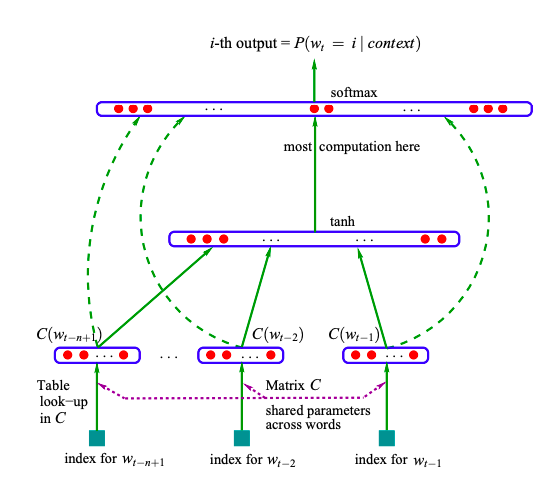


## My LanguageModel

In [16]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size, residual_connection):
        """
        Implements the Neural Language Model proposed by Bengio et al."

        Args:
            vocab_size (int): Size of the input vocabulary.
            context_size (int): Size of the sequence to consider as context for prediction.
            embedding_dim (int): Dimension of the embedding layer for each word in the context.
            hidden_size (int): Size of the hidden layer.
        """
        # Aumento de mais uma camada, inspirado na proposta da colega Larissa Santesso
        # e uso de conexão residual (bypass), inspirado na proposta do colega Marcus Borela
        super().__init__()
        self.residual_connection = residual_connection
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear_layer1 = nn.Linear(context_size*embedding_dim, hidden_size)
        self.linear_layer2 = nn.Linear(hidden_size, hidden_size*2)
        self.linear_layer3 = nn.Linear(hidden_size*2, vocab_size, bias=False)
        self.relu = nn.ReLU()
        if residual_connection: # residual bypass connection: y = b + Wx + U*tanh(d +Hx)
          self.residual = nn.Linear(context_size * embedding_dim, vocab_size, bias=True)
    def forward(self, inputs):
        """
        Args:
            inputs is a LongTensor of shape (batch_size, context_size)
        """
        # Escreva seu código aqui.
        out = self.embeddings(inputs)
        out = out.view(inputs.shape[0],-1)
        if self.residual_connection: embeddings = out
        out = self.linear_layer1(out)
        out = self.relu(out)
        out = self.linear_layer2(out)
        out = self.relu(out)
        out = self.linear_layer3(out)
        if self.residual_connection:
          out += self.residual(embeddings) 
        return out

## Teste o modelo com um exemplo

In [17]:
model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=64,
    hidden_size=128,
    residual_connection=False
).to(device)


sample_train, _ = next(iter(DataLoader(training_dataset)))
sample_train_gpu = sample_train.to(device)
model(sample_train_gpu).shape

torch.Size([1, 29794])

In [18]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Number of model parameters: 9640960


## Assert da Perplexidade


In [19]:
set_seeds()


def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity.
    """
    # Escreva seu código aqui.
     
    return torch.exp(nn.functional.cross_entropy(logits,target))


n_examples = 1000

sample_train, target_token_ids = next(iter(DataLoader(training_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)

my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=2000)
print('Passou o no assert da perplexidade')

my perplexity:              30251
correct initial perplexity: 29794
Passou o no assert da perplexidade


## Laço de Treinamento e Validação

In [20]:

params = {
    'max_examples': 100_000_000,
    'eval_every_steps': 5000,
    'lr': 3e-5,
    'batch_size': 1024,
    'embedding_dim': 128,
    'hidden_size': 256,
    'optimizer': 'Adam',
    'residual_connection': False
}
run['parameters'] = params

model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=params['embedding_dim'],
    hidden_size=params['hidden_size'],
    residual_connection = params['residual_connection']
).to(device)


model = torch.load("gdrive/MyDrive/Colab Notebooks/"+"best_model_Aula7_sem_res_batch1024.pt")
model.to(device)


train_loader = DataLoader(training_dataset, batch_size=params['batch_size'], shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=params['batch_size'])

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])


def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input.to(device))
    loss = nn.functional.cross_entropy(logits, target.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def validation_step(input, target):
    logits = model(input)
    loss = nn.functional.cross_entropy(logits, target)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
best_valid_ppl = 10e9
while n_examples < params['max_examples']:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        run['train/loss'].log(loss) # Envia loss para o Neptune.
        if step % params['eval_every_steps'] == 0:
            train_ppl = np.exp(np.average(train_losses))
            run['train/ppl'].log(train_ppl) # Envia train ppl para o Neptune.

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))
                run['valid/ppl'].log(valid_ppl) # Envia valid ppl para o Neptune.
            
                if checkinpoint and valid_ppl < best_valid_ppl:
                  torch.save(model.state_dict(), 'best_model.pt')
                  if save_in_drive: torch.save(model, "gdrive/MyDrive/Colab Notebooks/"+"best_model_Aula7.pt")
                  print(f"Best model found in step {step}. valid ppl: {valid_ppl:.2f}, best_valid_ppl: {best_valid_ppl:.2f} ")
                  best_valid_ppl = valid_ppl
                  
            ex_least = params['max_examples']-n_examples
            print(f'{step} steps; {n_examples} examples so far; at least {ex_least} examples to go; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}, best_valid_ppl: {best_valid_ppl:.2f}')
            train_losses = []
            
        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >= params['max_examples']:
            break

Best model found in step 0. valid ppl: 195.35, best_valid_ppl: 10000000000.00 
0 steps; 0 examples so far; at least 100000000 examples to go; train ppl: 210.31, valid ppl: 195.35, best_valid_ppl: 195.35
5000 steps; 5120000 examples so far; at least 94880000 examples to go; train ppl: 183.71, valid ppl: 196.78, best_valid_ppl: 195.35
Best model found in step 10000. valid ppl: 193.87, best_valid_ppl: 195.35 
10000 steps; 10240000 examples so far; at least 89760000 examples to go; train ppl: 180.98, valid ppl: 193.87, best_valid_ppl: 193.87
Best model found in step 15000. valid ppl: 191.70, best_valid_ppl: 193.87 
15000 steps; 15360000 examples so far; at least 84640000 examples to go; train ppl: 178.83, valid ppl: 191.70, best_valid_ppl: 191.70
Best model found in step 20000. valid ppl: 189.77, best_valid_ppl: 191.70 
20000 steps; 20480000 examples so far; at least 79520000 examples to go; train ppl: 177.32, valid ppl: 189.77, best_valid_ppl: 189.77
Best model found in step 25000. valid 

## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

In [21]:
best_model = 'best_model.pt'
model.load_state_dict(torch.load(best_model))

test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')
run['test/perplexity'].log(test_ppl)

test perplexity: 159.23393912908722


In [22]:
run.stop()


Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.


All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-67


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [23]:
prompt = 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz com
Eu gosto de comer pizza pois me faz com que
Eu gosto de comer pizza pois me faz com que o
Eu gosto de comer pizza pois me faz com que o que
Eu gosto de comer pizza pois me faz com que o que é
Eu gosto de comer pizza pois me faz com que o que é o
Eu gosto de comer pizza pois me faz com que o que é o que
Eu gosto de comer pizza pois me faz com que o que é o que é
Eu gosto de comer pizza pois me faz com que o que é o que é o
Eu gosto de comer pizza pois me faz com que o que é o que é o que


In [24]:
prompt ='Ouviram do Ipiranga às margens'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Ouviram do Ipiranga às margens do
Ouviram do Ipiranga às margens do Sul
Ouviram do Ipiranga às margens do Sul.
Ouviram do Ipiranga às margens do Sul. O
Ouviram do Ipiranga às margens do Sul. O primeiro
Ouviram do Ipiranga às margens do Sul. O primeiro é
Ouviram do Ipiranga às margens do Sul. O primeiro é o
Ouviram do Ipiranga às margens do Sul. O primeiro é o primeiro
Ouviram do Ipiranga às margens do Sul. O primeiro é o primeiro,
Ouviram do Ipiranga às margens do Sul. O primeiro é o primeiro, o


In [25]:
prompt ='A galinha atravessou a rua para chegar'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

A galinha atravessou a rua para chegar a
A galinha atravessou a rua para chegar a um
A galinha atravessou a rua para chegar a um ano
A galinha atravessou a rua para chegar a um ano.
A galinha atravessou a rua para chegar a um ano. O
A galinha atravessou a rua para chegar a um ano. O que
A galinha atravessou a rua para chegar a um ano. O que é
A galinha atravessou a rua para chegar a um ano. O que é o
A galinha atravessou a rua para chegar a um ano. O que é o primeiro
A galinha atravessou a rua para chegar a um ano. O que é o primeiro passo


In [26]:
prompt ='Ouça com cuidado, o segredo para a felicidade é'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Ouça com cuidado, o segredo para a felicidade é a
Ouça com cuidado, o segredo para a felicidade é a sua
Ouça com cuidado, o segredo para a felicidade é a sua vida
Ouça com cuidado, o segredo para a felicidade é a sua vida.
Ouça com cuidado, o segredo para a felicidade é a sua vida. O
Ouça com cuidado, o segredo para a felicidade é a sua vida. O que
Ouça com cuidado, o segredo para a felicidade é a sua vida. O que é
Ouça com cuidado, o segredo para a felicidade é a sua vida. O que é o
Ouça com cuidado, o segredo para a felicidade é a sua vida. O que é o que
Ouça com cuidado, o segredo para a felicidade é a sua vida. O que é o que é


In [27]:
prompt ='Desejo a todas as inimigas vida longa'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Desejo a todas as inimigas vida longa,
Desejo a todas as inimigas vida longa, e
Desejo a todas as inimigas vida longa, e o
Desejo a todas as inimigas vida longa, e o que
Desejo a todas as inimigas vida longa, e o que é
Desejo a todas as inimigas vida longa, e o que é o
Desejo a todas as inimigas vida longa, e o que é o que
Desejo a todas as inimigas vida longa, e o que é o que é
Desejo a todas as inimigas vida longa, e o que é o que é o
Desejo a todas as inimigas vida longa, e o que é o que é o que
